В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [16]:
import pandas as pd
%reload_ext autoreload
%autoreload 2

from process_bank_churn import process_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.base import ClassifierMixin
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import time





In [31]:
bank_df = pd.read_csv("/content/train.csv")
data = process_data("/content/train.csv", target_col='Exited', poly_degree=2)
X_train = data['train_X']
train_targets = data['train_y']
X_val = data['val_X']
val_targets = data['val_y']

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [33]:
knn = KNeighborsClassifier()
knn.fit(X_train, train_targets)

KNeighborsClassifier()

In [34]:
def evaluate_model(model: ClassifierMixin, X_train: pd.DataFrame, y_train: np.ndarray,
                   X_val: pd.DataFrame, y_val: np.ndarray) -> None:
    """
    Обчислює та виводить AUC-ROC для тренувального та валідаційного наборів.

    :param model: Навчена модель (класифікатор).
    :param X_train: pd.DataFrame, тренувальні ознаки.
    :param y_train: np.ndarray, мітки для тренувального набору.
    :param X_val: pd.DataFrame, валідаційні ознаки.
    :param y_val: np.ndarray, мітки для валідаційного набору.
    """
    # Отримання ймовірностей для позитивного класу
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]

    # Обчислення AUC-ROC
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    val_auc = roc_auc_score(y_val, y_val_pred_proba)

    # Вивід результатів
    print(f"Train AUC-ROC: {train_auc:.4f}")
    print(f"Validation AUC-ROC: {val_auc:.4f}")

    # Аналіз перенавчання або недонавчання
    if train_auc > val_auc + 0.1:
        print("Є ознаки перенавчання (overfitting).")
    elif val_auc > train_auc + 0.1:
        print("Є ознаки недонавчання (underfitting).")
    else:
        print("Модель збалансована.")

In [35]:
evaluate_model(knn, X_train, train_targets, X_val, val_targets)


Train AUC-ROC: 0.8217
Validation AUC-ROC: 0.5697
Є ознаки перенавчання (overfitting).


2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [36]:
params_knn = {'n_neighbors': range(1, 51)}
knn_gs = GridSearchCV(KNeighborsClassifier(), params_knn, cv=5, scoring='roc_auc', verbose=1)
start_time = time.time()
knn_gs.fit(X_train, train_targets)
end_time = time.time()

# Час виконання
execution_time = end_time - start_time
print(f"Час виконання GridSearchCV: {execution_time:.2f} секунд")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Час виконання GridSearchCV: 57.68 секунд


In [37]:
best_n_neighbors = knn_gs.best_params_['n_neighbors']
knn_best = knn_gs.best_estimator_

print(f"Найкраще значення n_neighbors: {best_n_neighbors}")
evaluate_model(knn_best, X_train, train_targets, X_val, val_targets)

Найкраще значення n_neighbors: 50
Train AUC-ROC: 0.6560
Validation AUC-ROC: 0.6202
Модель збалансована.


Модель заперформила краще, ніж попередня, але значно гірше, ніж в деревах прийняття рішень, бо там значення було майже 0.9


3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [38]:
param_grid = {
    'max_depth': range(1, 21, 2),
    'max_leaf_nodes': range(2, 11, 1)
}

dt = DecisionTreeClassifier(random_state=42)

# Запуск GridSearchCV
grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)

start_time = time.time()
grid_search.fit(X_train, train_targets)
end_time = time.time()

# Час виконання
execution_time = end_time - start_time

# Отримання найкращої моделі
best_params = grid_search.best_params_
dt_best = grid_search.best_estimator_

print(f"Час виконання GridSearchCV: {execution_time:.2f} секунд")
print(f"Найкращі параметри: {best_params}")
evaluate_model(dt_best, X_train, train_targets, X_val, val_targets)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
Час виконання GridSearchCV: 19.51 секунд
Найкращі параметри: {'max_depth': 5, 'max_leaf_nodes': 10}
Train AUC-ROC: 0.9014
Validation AUC-ROC: 0.8961
Модель збалансована.


Ця модель набагато краща за кнн, але вручну підібрані параметри показали кращий результат - > 0,91

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [39]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [40]:
dt = DecisionTreeClassifier(random_state=42)

# Запуск GridSearchCV
random_search = RandomizedSearchCV(
    dt, params_dt, n_iter=40, cv=3,
    scoring='roc_auc', random_state=42, n_jobs=-1, verbose=1
)

start_time = time.time()
random_search.fit(X_train, train_targets)
end_time = time.time()

execution_time = end_time - start_time

best_params = random_search.best_params_
dt_best = random_search.best_estimator_

print(f"Час виконання GridSearchCV: {execution_time:.2f} секунд")
print(f"Найкращі параметри: {best_params}")
evaluate_model(dt_best, X_train, train_targets, X_val, val_targets)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Час виконання GridSearchCV: 2.90 секунд
Найкращі параметри: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}
Train AUC-ROC: 0.9143
Validation AUC-ROC: 0.9104
Модель збалансована.


Модель заперформила майже однаково на тренувальних та валідаційних даних. Проте загалом все ж таки простіша модель (model = DecisionTreeClassifier(max_depth=5, random_state=42)
) показувала трохи кращі результати

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [42]:
test_inputs = process_data('/content/test.csv', poly_degree=2)
probs = dt_best.predict_proba(test_inputs['X'])[:,1]

submission = pd.read_csv('sample_submission.csv')
submission['Exited'] = probs
submission.to_csv('submission_best_params_poly_2.csv', index=False)
submission['Exited'].head()

,Exited
0,0.064890
1,0.012053
2,0.147132
3,0.881070
4,0.078462


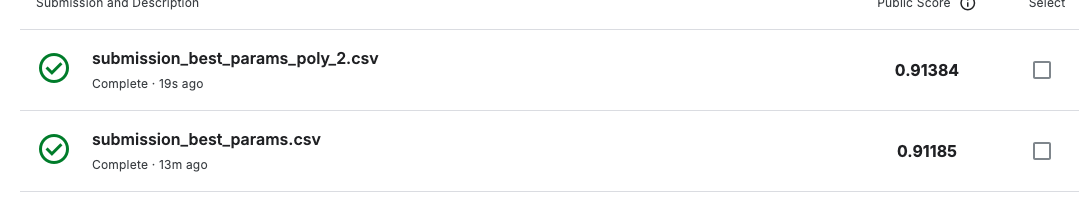